In [8]:
# Fetch the path for essential python scripts

import os
import sys
path =  os.getcwd()
# Avoid Windows users to have issues with how paths are written
path = path.replace('\\','/')

# Import python scripts from notebooks folder
sys.path.append(path + '/scripts')

In [9]:
import netCDF4 as ncf
import torch
import pickle
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# Import all the necessary packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import xarray as xr
import numpy as np
import pandas as pd
import glob
import warnings
import shutil
from pathlib import Path

In [80]:
# Choose your glacier ('hubbard' or 'turner')
glacier = 'hubbard'

qual_threshold = 0.1
var = 'vx'

list_files = glob.glob(f'{path}/Datacubes/Subyearly/Alaska/-139.95_59.96_-139.11_60.23/*')

# Select your date inpute (goes to 2023-02-17)
sdate = '2013-01-01'
edate = '2023-02-17'

# Number of modes for the SVD
n_modes = 10
# Number of iterations for the steepest descent
n_iter = 500

In [81]:
# Grab the time values
lentime = 0
s = 0
while lentime == 0:
    t = xr.open_dataset(list_files[s]).mid_date.values
    # Create a time mask, based on the validity of layers and the custom date-range
    t_mask = np.logical_and(t>=np.datetime64(sdate), t<=np.datetime64(edate))
    lentime = len(np.where(t_mask==True)[0])
    s += 1
    
s -= 1
ds = xr.open_dataset(list_files[s]).sel(mid_date=t_mask)


for i in range(s, len(list_files)):
    t = xr.open_dataset(list_files[i]).mid_date.values
    t_mask = np.logical_and(t>=np.datetime64(sdate), t<=np.datetime64(edate))
    if len(np.where(t_mask==True)[0]) > 0:
        temp = xr.open_dataset(list_files[i]).sel(mid_date=t_mask)

        ds = xr.concat((ds,temp),dim='mid_date')



# Rename the time dimension so we don't have to modify the entire code
ds = ds.rename({'mid_date': 'time'})

0 1.0000003576278687 8.316386811202392e-05 0.03286443278193474 0.008787714732722168
1 1.0022313594818115 0.006948080845177174 3.483428716659546 1.3047628308053334
2 1.000056266784668 0.0008391133742406964 0.33443376421928406 0.17298628424637572
3 1.0001442432403564 0.0016826987266540527 0.8643220663070679 0.3145630364585538
4 1.000635027885437 0.0037589638959616423 1.9182648658752441 0.7010109451345001
5 1.0002700090408325 0.0026038996875286102 1.2928545475006104 0.5182426309310542
6 0.9998650550842285 0.0007589873857796192 0.3439481258392334 0.17531717594520965
7 0.9996936917304993 0.00037445189082063735 0.16570788621902466 0.061199408585634205
8 0.999545693397522 0.0012948301155120134 0.6476547718048096 0.20933794877392148
9 0.9992591142654419 0.0019102642545476556 0.9556677341461182 0.34799433555202425
10 0.9985606670379639 0.0014724355423823 0.7184914946556091 0.29939682121535
11 0.9974531531333923 0.0006193009903654456 0.27603471279144287 0.14002951213652776
12 0.9958131909370422 

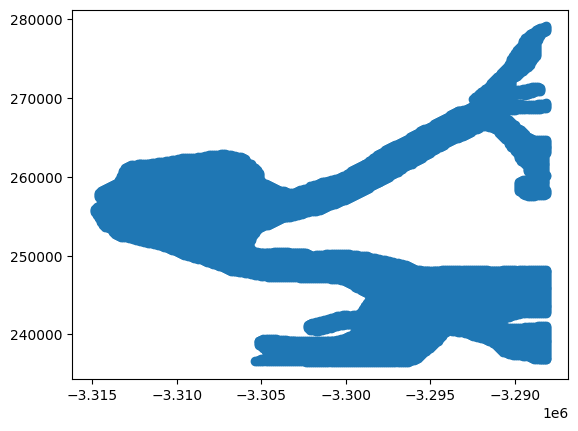

In [82]:
# Load datasets and append them
xs = ds.x.values
ys = ds.y.values
dst = ds.time.values

if var == 'vx':
    ds = ds.vx.values
elif var == 'vy':
    ds = ds.vy.values
elif var == 'v':
    ds = np.sqrt(ds.vx.values**2 + ds.vy.values**2)


# Calculate the quality of each slice
inds_quality = np.array([np.count_nonzero(~np.isnan(ds[i]))/(ds.shape[1]*ds.shape[2]) for i in range(ds.shape[0])])

# Keep only good quality images
ds = ds[inds_quality>qual_threshold]
dst = dst[inds_quality>qual_threshold]

# Sort the indices by date
inds = np.argsort(dst)

# Sort dates and variable
dst = dst[inds]
ds = ds[inds]

# Convert the NaNs to -1
ds[np.isnan(ds)==True] = -1
# Create a timedelta
dt = dst[1:] - dst[:-1]
# Convert to float
dt = dt / np.timedelta64(1, 's')
# Grab dimensions of the variable
n_t,n_row,n_col = ds.shape


# Load the boundary points
boundary_points = pd.read_csv(f'{path}/{glacier}_boundary_points_3413.csv')
Xs,Ys = np.meshgrid(xs,ys)
X = np.vstack((Xs.ravel(),Ys.ravel())).T


p = mpath.Path(np.vstack((boundary_points.X.values,boundary_points.Y.values)).T)
glacier_mask = p.contains_points(X)

plt.scatter(*X[glacier_mask].T)
# Create a glacier mask
glacier_mask = np.hstack([glacier_mask]*n_t).reshape(n_t,n_row,n_col)
mask_f = glacier_mask.reshape(ds.shape[0],-1).T





off_ice_means = np.zeros(ds.shape[0])
for i in range(ds.shape[0]):
    
    off_ice_means[i] = np.median(ds[i][(ds[i]!=-1) & (glacier_mask[i]==0)])
    ds[i][ds[i]!=-1] -= off_ice_means[i]
    
Uf = (ds).reshape(ds.shape[0],-1).T



# How many non-orthogonal modes to compute
l = 30

# Regularization strength on column-space (spreads out mode coefficients)
lamda_u = 10.0

# Regularization strength on row-space (makes it more likely to use more modes to describe a velocity field)
lamda_v = 1.0

# Penalizes mode gradients
lamda_x = 1000.0

# Penalizes variation in mode strength through time
lamda_t = 10000.0

# avoid divide by zero in time step (which is used in time-gradient regularization)
dt_0 = torch.from_numpy(dt + 1.0)

# Do some reshaping and rescaling
R = torch.from_numpy(Uf)
Rhat = R.ravel()
I_0 = Rhat!=-1.
I_1 = torch.from_numpy(mask_f.ravel())
I = I_0 & I_1
Rbar = Rhat[I]

Rmean = Rbar.mean()
Rstd = Rbar.std()

Rbar = (Rbar - Rmean)/Rstd

# Define low-rank matrix factors 
U_ = torch.randn(R.shape[0],l,requires_grad=True)
V_ = torch.randn(l,R.shape[1],requires_grad=True)

# Initialize
U_.data[:] *= 1e-2
V_.data[:] *= 1e-2

# Define an optimizer for gradient descent
optimizer = torch.optim.Adam([U_,V_],1e-1)

# Do 500 iterations of gradient descent
for i in range(n_iter):
    optimizer.zero_grad()
    
    # Compute the predicted matrix
    G = U_ @ V_
   
    # Compute the gradients of the right factor (the mode coefficients through time)
    dudt = (V_[:,1:] - V_[:,:-1])/dt_0
    
    # Reshape the left factor (columns hold the modes) into a grid and takes its gradients.
    U_grid = U_.T.reshape(l,n_row,n_col)    
    dudrow = U_grid[:,1:] - U_grid[:,:-1]
    dudcol = U_grid[:,:,1:] - U_grid[:,:,:-1]
    
    # Flatten and mask the predictions
    Gbar = G.ravel()[I]

    # Compute a variety of negative log likelihoods
    
    # Data misfit
    E_misfit = ((Rbar - Gbar)**2).mean() 
    #E_misfit = (torch.abs(Rbar - Gbar)).mean() 
    
    # norm regularization
    E_reg = lamda_u*(U_**2).sum()/len(Rbar) + lamda_v*(V_**2).sum()/len(Rbar)
    
    # Spatial gradient regularization
    E_space = lamda_x/len(Rbar)*((dudrow**2).sum() + (dudcol**2).sum())  
    
    # Time gradient regularization
    E_time = lamda_t/len(Rbar)*(dudt**2).sum()
    
    # Sum to form total cost
    E = E_misfit + E_reg + E_space + E_time
    
    # Backpropagate gradients
    E.backward()
    
    # Update factors
    optimizer.step()
    print(i,E_misfit.item(),E_reg.item(),E_space.item(),E_time.item())

u,s,v = torch.svd_lowrank(U_.detach()@V_.detach(),n_modes)
U_recon = ((u * s) @ v.T).T.reshape(n_t,n_row,n_col)

In [84]:
path =  os.getcwd()
# Avoid Windows users to have issues with how paths are written
path = path.replace('\\','/')

U_recon[glacier_mask==False] = np.nan

datacube_recon = xr.Dataset(
    data_vars=dict(
        var=(["time", "y", "x"], U_recon*365)),
    coords=dict(
        time=(["time"],dst),
        y=(["y"], ys),
        x=(["x"], xs),
    ),
    attrs=dict(description=f"Interpolated {var} between {sdate} and {edate}"),
)


# Create SVD folder if it doesn't already exist
Path(f'{path}/SVD/').mkdir(parents=True, exist_ok=True)

# Save .nc file
datacube_recon.to_netcdf(f'{sdate}_{edate}_{var}.nc')

# Move it to the SVD folder (somehow I couldn't save it there directly)
shutil.move(f'{sdate}_{edate}_{var}.nc', f'{path}/SVD/{sdate}_{edate}_{var}.nc')

'/home/annegret/Projects/CryohackathonAlaska2023/SVD/2013-01-01_2023-02-17_vx.nc'